Learn the corrected Jacobi iterator (H) for single-phase problems 
* The iterator is shared by different grids 
* Dataset is constructed by changing RHS & Dirichlet boundary conditions
* Restriction and Prolongation kernels are assumed to be the linear

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from functools import reduce

from FEANet.mesh import MeshSquare
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet

from Utils import plot
from Data.dataset import IsoPoissonDataSet

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def ResetBoundary(self, bc_idx, bc_values):
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, bc_idx, bc_values)

    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

In [3]:
n = 2**5
grid = SingleGrid(size=2,n=n)

In [4]:
model_name = 'iso_poisson_33x33'
training_set = IsoPoissonDataSet('Data/IsoPoisson/poisson2d_33x33.h5')
model_dir = 'Model/learn_iterator/iso_poisson'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

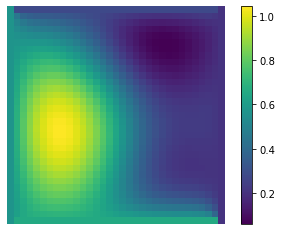

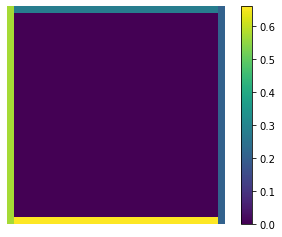

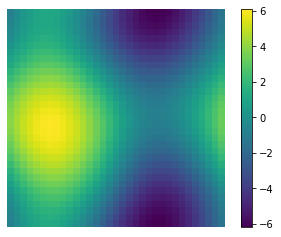

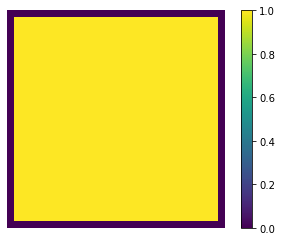

In [5]:
train_dataloader = DataLoader(training_set, batch_size=5, shuffle=True)
u_train, f_train, bc_value_train, bc_index_train = next(iter(train_dataloader))

k=0
plot.plot_field(u_train[k,0], fname='Results/u_train.jpg')
plot.plot_field(bc_value_train[k,0], fname='Results/bc_value_train.jpg')
plot.plot_field(f_train[k,0], fname='Results/f_train.jpg')
plot.plot_field(bc_index_train[k,0], fname='Results/bc_index.jpg')

0 3.0990309715270996
1 2.266483783721924
2 1.8290507793426514
3 1.5553375482559204
4 1.3661848306655884
5 1.2267310619354248
6 1.1191023588180542
7 1.0331438779830933
8 0.9626408219337463
9 0.9035681486129761
10 0.8532005548477173
11 0.8096251487731934
12 0.7714581489562988
13 0.7376736998558044
14 0.70749431848526
15 0.6803199648857117
16 0.6556798219680786
17 0.6331992745399475
18 0.6125761270523071
19 0.5935641527175903
20 0.5759602785110474
21 0.5595957636833191
22 0.5443289875984192
23 0.5300400257110596
24 0.5166270136833191
25 0.5040022730827332
26 0.4920904338359833
27 0.48082584142684937
28 0.47015124559402466
29 0.4600165784358978
30 0.45037755370140076
31 0.44119495153427124
32 0.4324341118335724
33 0.4240637719631195
34 0.41605615615844727
35 0.4083864092826843
36 0.4010317027568817
37 0.3939717710018158
38 0.38718798756599426
39 0.38066351413726807
40 0.37438303232192993
41 0.3683323264122009
42 0.36249855160713196
43 0.3568696975708008
44 0.35143494606018066
45 0.34618407

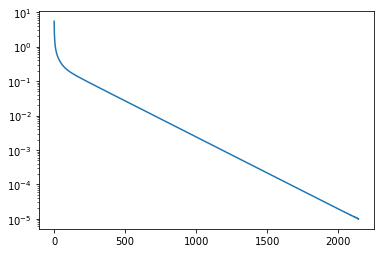

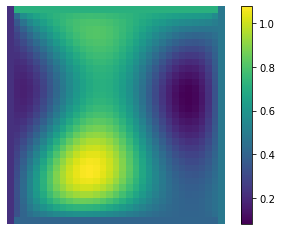

Solution from dataset:


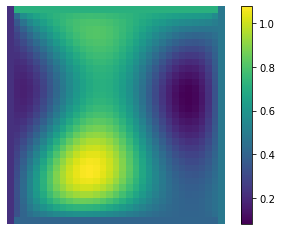

Error (dataset v.s. jacobi):


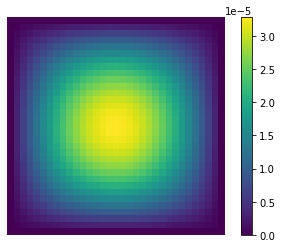

In [6]:
EPS = 1e-5
n_jac = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid.fnet(f_train[k,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid.ResetBoundary(bc_index_train[k,0].reshape((1,1,n+1,n+1)), bc_value_train[k,0].reshape((1,1,n+1,n+1)))
u_test = grid.jac.reset_boundary(u_test)
residual = f_test-grid.Knet(u_test)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
res_arr = [res]
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(u_test, f_test)
    residual = f_test-grid.Knet(u_test)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. jacobi):")
plot.plot_field(u_train[k,0]-u_test.detach().reshape((1,1,n+1,n+1)))

In [7]:
class HNet(nn.Module):
    def __init__(self, nb_layers):
        super(HNet, self).__init__()

        self.convLayers = nn.ModuleList([nn.Conv2d(1, 1, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, x, geo_idx):
        '''geo_idx: internal points 1; boundary points 0'''
        return reduce(lambda acc, el: el(acc) * geo_idx, self.convLayers, x)

In [8]:
class HJacIterator(nn.Module):
    def __init__(self, 
                 size=2, 
                 hnet=None,
                 grid=None,
                 n=2**5,
                 batch_size=5,
                 max_epochs=1000,
                 nb_layers=3,
                 model_dir='Model/learn_iterator/iso_poisson'):
        super(HJacIterator, self).__init__()
        self.size = size
        self.n = n
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss(reduction='sum')
        
        if(grid is None):
            self.grid = SingleGrid(size, n)
        else:
            self.grid = grid

        if(hnet is None):
            self.net = HNet(nb_layers)
        else:
            self.net = hnet

        self.optimizer = torch.optim.Adadelta(self.net.parameters())
        self.model_dir=model_dir

    def HRelax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of modified Jacobi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(u, f)
            u = jac_it + self.net(jac_it-u, self.grid.jac.geometry_idx)
        return u

    def RandomSampling(self, x):
        u = torch.randn_like(x)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            u_train, f_train, bc_value_train, bc_index_train = data
        
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = 1 #random.randint(1,20)

            self.grid.ResetBoundary(bc_index_train, bc_value_train)
            ff = self.grid.fnet(f_train)
            uu = self.RandomSampling(f_train)
            
            u_out = self.HRelax(uu, ff, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train


Step-0 loss: 2448.6906005859373
Step-50 loss: 1395.6390197753906
Step-100 loss: 1440.7793853759765
Step-150 loss: 1437.6357452392579
Step-200 loss: 1415.3953582763672
Step-250 loss: 1425.2761962890625
Step-300 loss: 1415.73173828125
Step-350 loss: 1420.9621704101562
Step-400 loss: 1404.5261474609374
Step-450 loss: 1423.7040893554688
Step-500 loss: 1395.604653930664
Step-550 loss: 1467.5677520751954
Step-600 loss: 1413.9086120605468
Step-650 loss: 1442.155953979492
Step-700 loss: 1413.3970733642577
Step-750 loss: 1434.0013458251954
Step-800 loss: 1452.8083374023438
Step-850 loss: 1435.9465637207031
Step-900 loss: 1439.6261108398437
Step-950 loss: 1409.610595703125
Average q:  tensor(1421.9301) , STD:  tensor(14.1165)


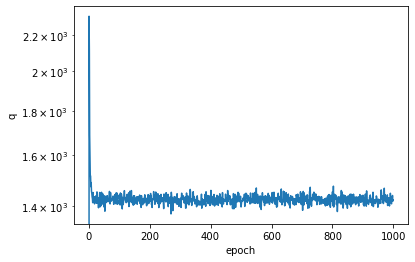

In [9]:
my_iterator = HJacIterator()
loss_train = my_iterator.Train(training_set)

plt.plot(loss_train)
plt.ylabel('q')
plt.yscale('log')
plt.xlabel('epoch')
print("Average q: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

In [10]:
# save the list
torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))

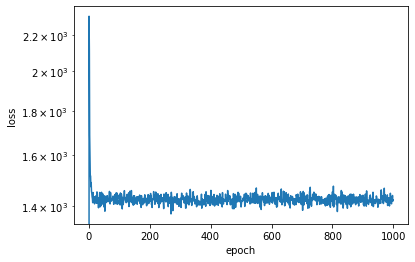

In [11]:
# import the learned model and loss train
my_hnet = HNet(nb_layers=3)
my_hnet.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = HJacIterator(hnet=my_hnet, grid=grid)

my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('Results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

0 5.484145641326904
1 1.8807109594345093
2 0.7726890444755554
3 0.4748961627483368
4 0.36908549070358276
5 0.31251609325408936
6 0.2744646966457367
7 0.24633747339248657
8 0.2244941145181656
9 0.20689207315444946
10 0.19224122166633606
11 0.17969469726085663
12 0.16868898272514343
13 0.1588463932275772
14 0.1499110907316208
15 0.14170679450035095
16 0.13411039113998413
17 0.12703293561935425
18 0.12040920555591583
19 0.11418887972831726
20 0.10833299160003662
21 0.10280957072973251
22 0.09759233891963959
23 0.0926586389541626
24 0.0879891961812973
25 0.08356629312038422
26 0.07937479764223099
27 0.07540077716112137
28 0.07163137942552567
29 0.06805505603551865
30 0.0646609291434288
31 0.061438966542482376
32 0.058379970490932465
33 0.05547509714961052
34 0.052716344594955444
35 0.05009597912430763
36 0.047606825828552246
37 0.04524220898747444
38 0.04299566522240639
39 0.04086120426654816
40 0.03883307799696922
41 0.036905936896800995
42 0.03507461026310921
43 0.03333437442779541
44 0.

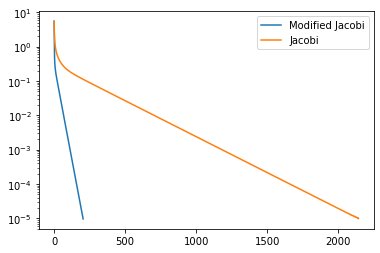

New solution:


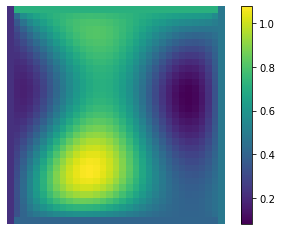

Solution from dataset:


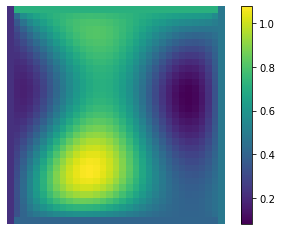

Error (dataset v.s. jacobi):


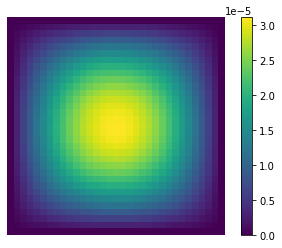

In [12]:
EPS = 1e-5
n_jac_new = 0
u_new = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid.fnet(f_train[k,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid.ResetBoundary(bc_index_train[k,0].reshape((1,1,n+1,n+1)), bc_value_train[k,0].reshape((1,1,n+1,n+1)))
u_new = grid.jac.reset_boundary(u_new)
residual = f_test-grid.Knet(u_new)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
res_arr_new = [res]
print(n_jac_new, res)
while (abs(res) > EPS):
    n_jac_new += 1
    u_new = new_iterator.HRelax(u_new, f_test, 1)
    residual = f_test-grid.Knet(u_new)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr_new.append(res)
    print(n_jac_new, res)

print("Solution converges after", n_jac_new, "modified Jacobi iterations ")
plt.plot(res_arr_new, label='Modified Jacobi')
plt.plot(res_arr, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()

print("New solution:")
plot.plot_field(u_new.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. jacobi):")
plot.plot_field(u_train[k,0]-u_new.detach().reshape((1,1,n+1,n+1)))

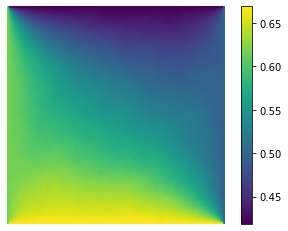

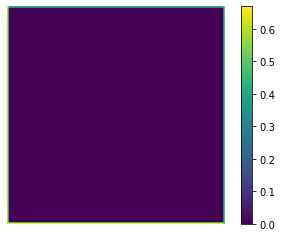

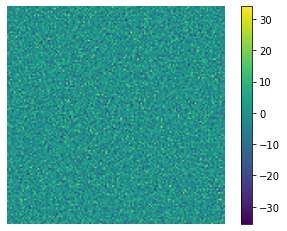

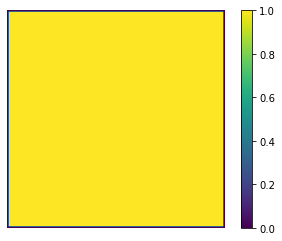

In [13]:
# test on larger grid
test_set = IsoPoissonDataSet('Data/IsoPoisson/poisson2d_129x129.h5')
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)
u_test, f_test, bc_value_test, bc_index_test = next(iter(test_dataloader))

kk=0
plot.plot_field(u_test[kk,0])
plot.plot_field(bc_value_test[kk,0])
plot.plot_field(f_test[kk,0])
plot.plot_field(bc_index_test[kk,0])

In [14]:
n = 2**7
grid_test = SingleGrid(size=2,n=n)

EPS = 5e-5
n_jac = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid_test.fnet(f_test[kk,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid_test.ResetBoundary(bc_index_test[kk,0].reshape((1,1,n+1,n+1)), bc_value_test[kk,0].reshape((1,1,n+1,n+1)))
u_test = grid_test.jac.reset_boundary(u_test)
residual = f_test-grid_test.Knet(u_test)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
res_arr_test = [res]
print(n_jac, res)
while (abs(res) > EPS):
    u_test = grid_test.jac.jacobi_convolution(u_test, f_test)
    residual = f_test-grid_test.Knet(u_test)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr_test.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")

0 12.634638786315918
0 7.068776607513428
1 5.121732234954834
2 4.0920586585998535
3 3.4438283443450928
4 2.993586540222168
5 2.6603639125823975
6 2.4025232791900635
7 2.1963233947753906
8 2.027174711227417
9 1.8855868577957153
10 1.7651020288467407
11 1.66116464138031
12 1.570462942123413
13 1.4905273914337158
14 1.4194773435592651
15 1.3558534383773804
16 1.2985048294067383
17 1.2465105056762695
18 1.199125051498413
19 1.155737280845642
20 1.1158418655395508
21 1.0790163278579712
22 1.044905424118042
23 1.013207197189331
24 0.9836641550064087
25 0.9560545086860657
26 0.9301867485046387
27 0.9058941602706909
28 0.8830311894416809
29 0.8614697456359863
30 0.8410974144935608
31 0.8218141198158264
32 0.8035310506820679
33 0.7861691117286682
34 0.7696574330329895
35 0.7539324760437012
36 0.7389367818832397
37 0.7246184945106506
38 0.7109309434890747
39 0.6978315114974976
40 0.6852812767028809
41 0.6732451319694519
42 0.6616906523704529
43 0.6505882143974304
44 0.6399106979370117
45 0.62963

0 12.633927345275879
1 3.0840933322906494
2 1.2720890045166016
3 0.8380628824234009
4 0.6634716391563416
5 0.5618279576301575
6 0.49181148409843445
7 0.4395892918109894
8 0.39878571033477783
9 0.3658697009086609
10 0.3386707901954651
11 0.3157650828361511
12 0.2961742579936981
13 0.2792012095451355
14 0.26433509588241577
15 0.2511919140815735
16 0.2394772171974182
17 0.2289613038301468
18 0.21946203708648682
19 0.21083304286003113
20 0.2029552161693573
21 0.19573065638542175
22 0.18907813727855682
23 0.18292957544326782
24 0.17722740769386292
25 0.17192286252975464
26 0.16697381436824799
27 0.16234441101551056
28 0.1580033153295517
29 0.15392328798770905
30 0.15008042752742767
31 0.14645376801490784
32 0.14302490651607513
33 0.13977724313735962
34 0.13669633865356445
35 0.1337689906358719
36 0.1309836059808731
37 0.1283295601606369
38 0.12579743564128876
39 0.12337867170572281
40 0.12106552720069885
41 0.11885080486536026
42 0.11672820895910263
43 0.11469177156686783
44 0.1127361804246

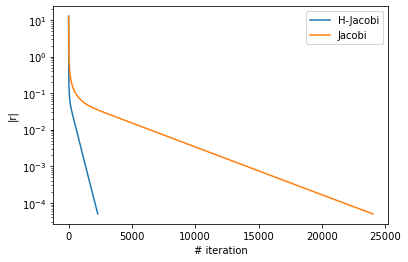

In [15]:
test_iterator = HJacIterator(hnet=my_hnet, grid=grid_test)

EPS = 5e-5
n_jac_test = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid_test.fnet(f_test[kk,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid_test.ResetBoundary(bc_index_test[kk,0].reshape((1,1,n+1,n+1)), bc_value_test[kk,0].reshape((1,1,n+1,n+1)))
u_test = grid_test.jac.reset_boundary(u_test)
residual = f_test-grid_test.Knet(u_test)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
res_arr_testnew = [res]
print(n_jac_test, res)
while (abs(res) > EPS):
    n_jac_test += 1
    u_test = test_iterator.HRelax(u_test, f_test, 1)
    residual = f_test-grid_test.Knet(u_test)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr_testnew.append(res)
    print(n_jac_test, res)

print("Solution converges after", n_jac_test, "modified Jacobi iterations ")
plt.plot(res_arr_testnew, label='H-Jacobi')
plt.plot(res_arr_test, label='Jacobi')
plt.yscale('log')
plt.ylabel('|r|')
plt.xlabel('# iteration')
plt.legend()
#plt.show()
plt.savefig('Results/H_jacobi_convergence.jpg', dpi=500, bbox_inches='tight')

In [16]:
def heatmap2d(arr, fname, cbar = True):
    plt.imshow(arr,cmap='viridis',vmin=-1,vmax=1)
    if(cbar is True):
        plt.colorbar()
    plt.gcf()
    plt.axis('off')
    plt.savefig(fname, dpi=500, bbox_inches='tight')
    plt.show()

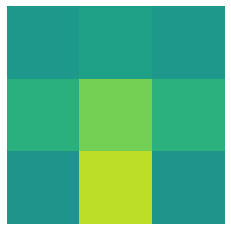

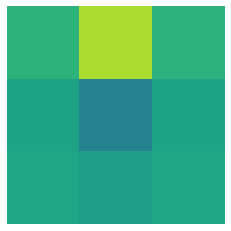

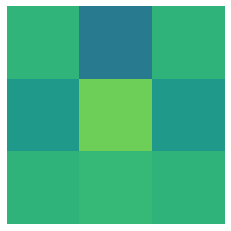

In [17]:
# plot the kernels
mlist = list(my_hnet.parameters())
heatmap2d(mlist[0].view(3,3).detach().numpy(),fname='Results/kernel1.jpg', cbar=False)
heatmap2d(mlist[1].view(3,3).detach().numpy(),fname='Results/kernel2.jpg', cbar=False)
heatmap2d(mlist[2].view(3,3).detach().numpy(),fname='Results/kernel3.jpg', cbar=False)

In [18]:
def conv_op(k1, k2, max_size=7):
    '''Perform convolution operation in infinite domain'''
    size1 = k1.shape[0]
    size2 = k2.shape[0]
    
    pad1 = int((max_size-size1)/2)
    pad2 = int((max_size-size2)/2)

    k1_pad = F.pad(k1,(pad1,pad1,pad1,pad1))
    k2_pad = F.pad(k2,(pad2,pad2,pad2,pad2))
    delta = int(max_size/2)

    out_k = torch.zeros((max_size,max_size))
    for u in range(-delta, -delta+max_size):
        for v in range(-delta, -delta+max_size):
            for i in range(-delta, -delta+max_size):
                for j in range(-delta, -delta+max_size):
                    ii = u-i 
                    jj = v-j 
                    multiplier = 0.0
                    if(ii >= -delta and ii <= delta and jj >= -delta and jj <= delta):
                        multiplier = k1_pad[ii+delta,jj+delta]
                    out_k[u+delta,v+delta] += multiplier * k2_pad[i+delta,j+delta]

    return out_k

In [19]:
kernel1 = conv_op(mlist[0].view(3,3).detach(), mlist[1].view(3,3).detach(), max_size=5)
kernel2 = conv_op(kernel1, mlist[2].view(3,3).detach(), max_size=7)
kernel2 = kernel2.reshape(1,1,7,7)

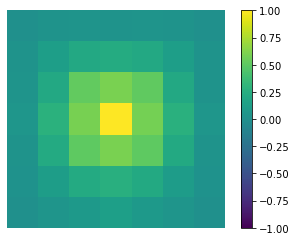

In [20]:
# combined kernel
heatmap2d(kernel2.view(7,7).detach().numpy(),fname='Results/kernel_comb.jpg')

In [21]:
a = torch.randint(0,10,size=(7,7)).float().reshape(1,1,7,7)
a

tensor([[[[3., 4., 2., 5., 8., 9., 9.],
          [8., 1., 1., 7., 4., 3., 4.],
          [4., 5., 3., 0., 1., 5., 0.],
          [7., 0., 6., 1., 4., 9., 6.],
          [2., 7., 6., 1., 4., 3., 7.],
          [3., 6., 5., 5., 1., 5., 9.],
          [4., 7., 5., 4., 6., 8., 0.]]]])

In [22]:
F.conv2d(a, kernel2)

tensor([[[[32.8051]]]])

In [23]:
temp = F.conv2d(a, mlist[0], padding=0)
temp = F.conv2d(temp, mlist[1], padding=0)
F.conv2d(temp, mlist[2], padding=0)

tensor([[[[32.8051]]]], grad_fn=<ConvolutionBackward0>)